<a href="https://colab.research.google.com/github/Ref4al/BWeek1/blob/main/WeeklyProject_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models

## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/MyDrive/B5-main/B5-main/intel"

'archive (4).zip'   extracted


In [5]:
!mkdir -p "/content/drive/MyDrive/B5-main/B5-main/intel/extracted"
!unzip -q "/content/drive/MyDrive/B5-main/B5-main/intel/archive (4).zip" -d "/content/drive/MyDrive/B5-main/B5-main/intel/extracted"

replace /content/drive/MyDrive/B5-main/B5-main/intel/extracted/seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
!find "/content/drive/MyDrive/B5-main/B5-main/intel/extracted" -maxdepth 4 -type d -name "seg_train" | head -n 10

/content/drive/MyDrive/B5-main/B5-main/intel/extracted/seg_train
/content/drive/MyDrive/B5-main/B5-main/intel/extracted/seg_train/seg_train


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [7]:
# YOUR CODE HERE
from pathlib import Path
from torchvision.datasets import ImageFolder

DATA_ROOT = Path("/content/drive/MyDrive/B5-main/B5-main/intel/extracted")

train_dir = DATA_ROOT / "seg_train" / "seg_train"
test_dir  = DATA_ROOT / "seg_test"  / "seg_test"

print("train_dir:", train_dir)
print("test_dir :", test_dir)

train_dir: /content/drive/MyDrive/B5-main/B5-main/intel/extracted/seg_train/seg_train
test_dir : /content/drive/MyDrive/B5-main/B5-main/intel/extracted/seg_test/seg_test


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [8]:
# YOUR CODE HERE
train_dataset = ImageFolder(str(train_dir))
test_dataset  = ImageFolder(str(test_dir))

print("Classes:", train_dataset.classes)
print("Train size:", len(train_dataset))
print("Test size :", len(test_dataset))

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train size: 14034
Test size : 3000


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [9]:
# YOUR CODE HERE
from collections import Counter

train_counts = Counter(train_dataset.targets)
test_counts  = Counter(test_dataset.targets)

print("Train:")
for i, name in enumerate(train_dataset.classes):
    print(name, train_counts[i])

print("\nTest:")
for i, name in enumerate(test_dataset.classes):
    print(name, test_counts[i])


Train:
buildings 2191
forest 2271
glacier 2404
mountain 2512
sea 2274
street 2382

Test:
buildings 437
forest 474
glacier 553
mountain 525
sea 510
street 501


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [10]:
# YOUR CODE HERE
from torchvision import transforms
img_size = 224

mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
    transforms.Resize(img_size + 32),
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize(img_size + 32),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [11]:
# YOUR CODE HERE
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(str(train_dir), transform=train_transform)
test_dataset  = ImageFolder(str(test_dir),  transform=test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [12]:
%cd "/content/drive/MyDrive/B5-main/B5-main/WeeklyProject"
import helper_utils
dir(helper_utils)

/content/drive/MyDrive/B5-main/B5-main/WeeklyProject


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'imshow',
 'np',
 'plt',
 'predict_single_image',
 'torch',
 'torchvision',
 'visualize_batch',
 'visualize_predictions',
 'visualize_single_prediction',
 'visualize_training_history']

**Quick Check**: Visualize a batch of training images

In [14]:
helper_utils.visualize_batch?

In [13]:
# YOUR CODE HERE

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

batch_size = 32

train_dataset = ImageFolder(str(train_dir), transform=train_transform)
test_dataset  = ImageFolder(str(test_dir),  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print(len(train_dataset), len(test_dataset))
print(train_dataset.classes)


14034 3000
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [15]:
# YOUR CODE HERE
from torchvision import models
import torch.nn as nn

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

print(model.fc)

Linear(in_features=512, out_features=6, bias=True)


<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [16]:
# YOUR CODE HERE
import torch

def train_model(model, train_loader, test_loader, loss_fn, opt, device, epochs=1):
    history = {"train_acc": [], "test_acc": []}

    for e in range(epochs):

        model.train()
        tr_ok, tr_n = 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()

            tr_ok += (out.argmax(1) == y).sum().item()
            tr_n  += y.size(0)


        model.eval()
        te_ok, te_n = 0, 0

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)

                te_ok += (out.argmax(1) == y).sum().item()
                te_n  += y.size(0)

        tr_acc = tr_ok / tr_n
        te_acc = te_ok / te_n

        history["train_acc"].append(tr_acc)
        history["test_acc"].append(te_acc)

        print(f"Epoch {e+1}/{epochs}  train_acc={tr_acc:.3f}  test_acc={te_acc:.3f}")

    return history

<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [17]:
# YOUR CODE HERE
from torchvision import models
import torch.nn as nn

num_classes = len(train_dataset.classes)

model_conv = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_conv.fc = nn.Linear(model_conv.fc.in_features, num_classes)
model_conv = model_conv.to(device)

In [18]:
# YOUR CODE HERE
for p in model_conv.parameters():
    p.requires_grad = False

for p in model_conv.fc.parameters():
    p.requires_grad = True

In [19]:
# YOUR CODE HERE
import torch

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_conv.fc.parameters(), lr=1e-3)

In [20]:
print("train batches:", len(train_loader), "test batches:", len(test_loader))
print("train samples:", len(train_loader.dataset), "test samples:", len(test_loader.dataset))

x, y = next(iter(train_loader))
print("one batch:", x.shape, y[:5])

train batches: 439 test batches: 94
train samples: 14034 test samples: 3000
one batch: torch.Size([32, 3, 224, 224]) tensor([4, 3, 1, 5, 4])


In [22]:
# YOUR CODE HERE
history_conv = train_model(model_conv, train_loader, test_loader, loss_fn, opt, device, epochs=1)

Epoch 1/1  train_acc=0.835  test_acc=0.890


**Quick Check**: Visualize training history

KeyError: 'train_loss'

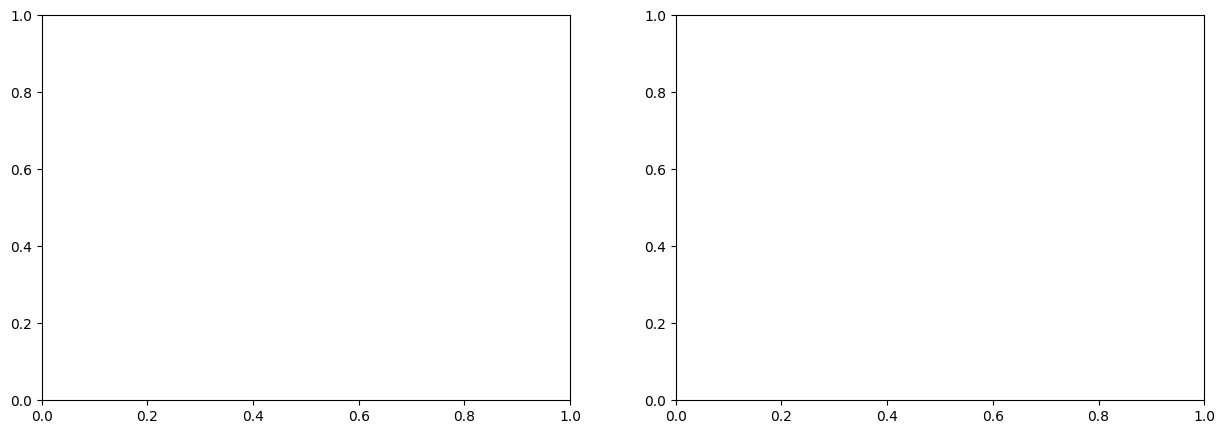

In [23]:
# helper_utils.visualize_training_history(history_conv)
# plt.show()
import helper_utils
helper_utils.visualize_training_history(history_conv)
plt.show()

**Quick Check**: Visualize predictions

In [ ]:
# helper_utils.visualize_predictions(model_conv, dataloaders['val'], class_names, device, num_images=6)
# plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE

**Quick Check**: Visualize training history

In [ ]:
# helper_utils.visualize_training_history(history_ft)
# plt.show()

**Quick Check**: Visualize predictions

In [ ]:
# helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
# plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [ ]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

# Print comparison
# print("Feature Extractor Approach:")
# print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
# print()
# print("Fine-tuning Approach:")
# print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

In [ ]:
# Make prediction on a custom image
# img_path = 'path/to/your/image.jpg'

# YOUR CODE HERE
# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
# helper_utils.visualize_single_prediction(
#     model_ft,  # or model_conv
#     img_path,
#     data_transforms['val'],
#     class_names,
#     device
# )
# plt.show()

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [ ]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
# model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
# onnx_path = 'model.onnx'
# torch.onnx.export(
#     model_ft,
#     dummy_input,
#     onnx_path,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"Model exported to {onnx_path}")

In [ ]:
# Load ONNX model and perform inference
# YOUR CODE HERE

# Load ONNX model
# ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
# img_path = 'path/to/test/image.jpg'
# img = Image.open(img_path).convert('RGB')
# img_tensor = data_transforms['val'](img).unsqueeze(0)
# img_numpy = img_tensor.numpy()

# Run inference
# outputs = ort_session.run(None, {'input': img_numpy})
# predictions = np.array(outputs[0])
# pred_class_idx = np.argmax(predictions[0])
# pred_class = class_names[pred_class_idx]
# confidence = np.max(predictions[0])

# print(f"Predicted: {pred_class} (confidence: {confidence:.2%})")